# Multiphase Systems

Kawin supports the usage of multiple phases. Nucleation and growth rate are handled for each precipitate phase independently. Coupling comes from the mass balance where all precipitates contribute to the overall mass changes in the system.

In the Al-Mg-Si system, several phases can form including: $ \beta' $, $ \beta" $, B', U1 and U2. To model precipitation of these phases, they must be defined in the .tdb file, the Thermodynamics module and the PrecipitateModel module.

When defining the thermodynamics module, the first phase in the list of phases will be the parent phase.

In [8]:
from kawin.thermo import MulticomponentThermodynamics

phases = ['FCC_A1', 'MGSI_B_P', 'MG5SI6_B_DP', 'B_PRIME_L', 'U1_PHASE', 'U2_PHASE']
therm = MulticomponentThermodynamics('AlMgSi.tdb', ['AL', 'MG', 'SI'], phases)

## Model inputs

Setting up parameters for the parent phase and overall system is the same as for single phase systems. Here, it is just the composition (Al-0.72Mg-0.57Si in mol. %), molar volume ($1e$-$5\text{ }m^3/mol$).

The temperature will be divided into two stages: a 16 hour temper at $175\text{ }^oC$, followed by a 1 hour ramp up to $250 ^oC$. To do this, there needs to be three time designations: $175\text{ }^oC$ at 0 hours, $175\text{ }^oC$ at 16 hours and $250\text{ }^oC$ at 17 hours. The temperature can be plotted to show the profile over time.

([0, 16, 17], [448.15, 448.15, 523.15])


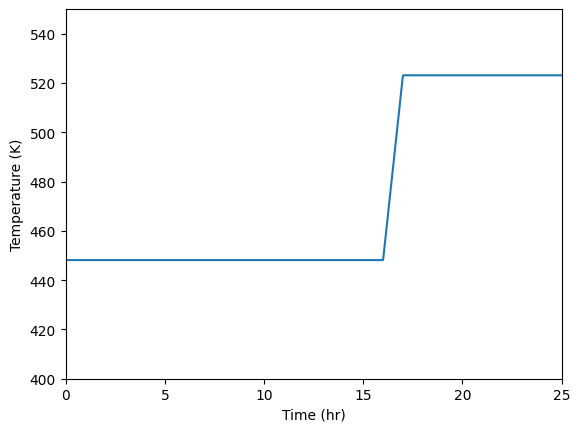

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from kawin.precipitation.PrecipitationParameters import TemperatureParameters

lowTemp = 175+273.15
highTemp = 250+273.15
temperature = TemperatureParameters([0, 16, 17], [lowTemp, lowTemp, highTemp])

time = np.linspace(0, 25*3600, 1000)
plt.plot(time/3600, temperature(time))
plt.xlim([0, 25])
plt.ylim([400, 550])
plt.xlabel('Time (hr)')
plt.ylabel('Temperature (K)')
plt.show()

Setting parameters for each precipitate phase is similar to single phase systems except that the phase has to be defined when inputting parameters.

In [10]:
from kawin.precipitation import MatrixParameters, PrecipitateParameters

matrix = MatrixParameters(['MG', 'SI'])
matrix.initComposition = [0.0072, 0.0057]
matrix.volume.setVolume(1e-5, 'VM', 4)

gamma = {
    'MGSI_B_P': 0.18,
    'MG5SI6_B_DP': 0.084,
    'B_PRIME_L': 0.18,
    'U1_PHASE': 0.18,
    'U2_PHASE': 0.18
        }

precipitates = []
for p in phases[1:]:
    params = PrecipitateParameters(p)
    params.gamma = gamma[p]
    params.volume.setVolume(1e-5, 'VM', 4)
    precipitates.append(params)

## Solving the model

As with single precipitate phase systems, running the model is exactly the same.

kawin currently implements two iterative methods for solving a model: Explicit euler and 4th order Runga Kutta. The Runga Kutta method is used by default, but we can input a different iterative method when solving. Here, we'll use explicit euler to have the model solve a bit faster.
- Another note: the solverType parameter in the solve function can take in either a SolverType enumerator or an Iterator from kawin.solver.Iterator which allows for custom iteration schemes that are not yet implemented in kawin to be used.

In [11]:
from kawin.precipitation import PrecipitateModel
from kawin.solver import SolverType

model = PrecipitateModel(matrix, precipitates, therm, temperature)
model.solve(25*3600, solverType=SolverType.EXPLICITEULER, verbose=True, vIt=10000)

C:\Users\ury3\OneDrive - LLNL\Documents\Projects\U-C Modeling\kawin-development\kawin\kawin\precipitation\NucleationRate.py:190: RuntimeWarning: divide by zero encountered in divide
  incubationTime = np.amin([np.exp(-tau[indices] / time), np.ones(tau[indices].shape)], axis=0)


N	Time (s)	Sim Time (s)	Temperature (K)	MG	SI	
0	0.0e+00		0.0		448		0.7200	0.5700	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	MGSI_B_P	0.000e+00		0.0000		0.0000e+00	1.2936e+04
	MG5SI6_B_DP	0.000e+00		0.0000		0.0000e+00	6.4822e+03
	B_PRIME_L	0.000e+00		0.0000		0.0000e+00	8.0257e+03
	U1_PHASE	0.000e+00		0.0000		0.0000e+00	7.5301e+03
	U2_PHASE	0.000e+00		0.0000		0.0000e+00	7.1719e+03

N	Time (s)	Sim Time (s)	Temperature (K)	MG	SI	
10000	6.1e+04		145.5		523		0.0631	0.2068	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	MGSI_B_P	2.552e+22		1.0228		4.5247e-09	7.9547e+02
	MG5SI6_B_DP	0.000e+00		0.0000		0.0000e+00	-4.5462e+03
	B_PRIME_L	6.007e+10		0.0000		1.1487e-09	-1.8483e+03
	U1_PHASE	0.000e+00		0.0000		0.0000e+00	1.2991e+03
	U2_PHASE	0.000e+00		0.0000		0.0000e+00	-3.5899e+02

N	Time (s)	Sim Time (s)	Temperature (K)	MG	SI	
17076	9.0e+04		238.6		523		0.0566	0.2032	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving

## Plotting

Plotting is also the same as with single phase systems. The major difference is each phase will be plotted for the radius, volume fraction, precipitate density, nucleation rate and particle size distribution. In addition, the total amount of some variables, such as the precipitate density and volume fraction, can be plotted.

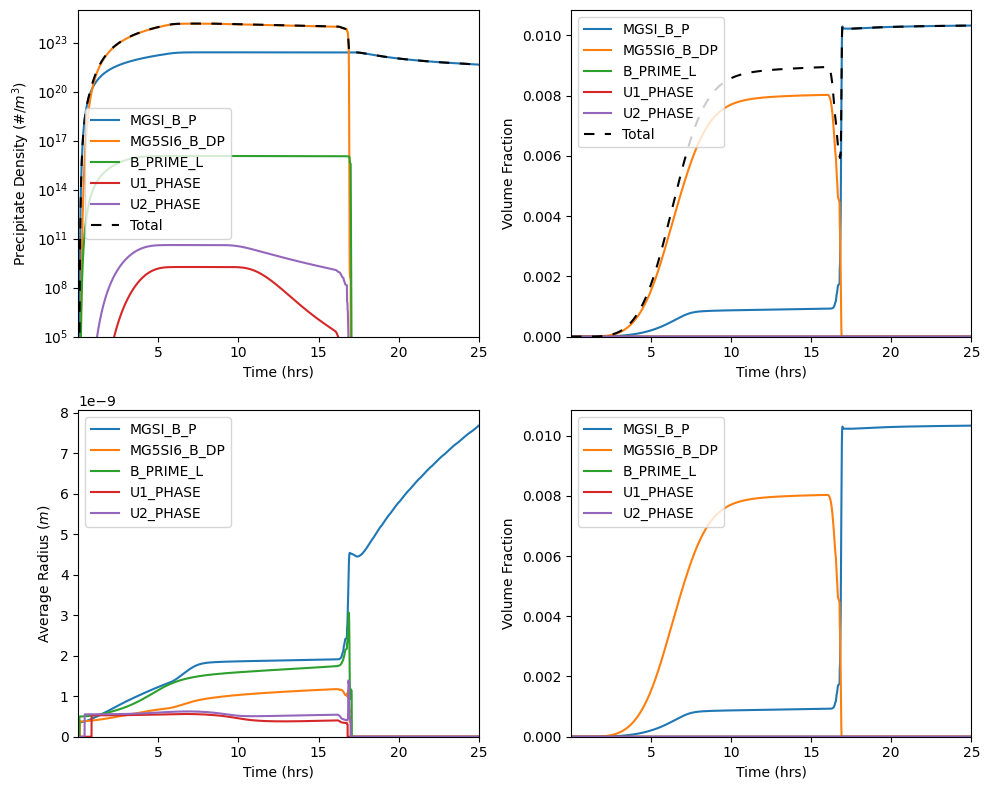

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from kawin.precipitation.Plot import plotPrecipitateDensity, plotVolumeFraction, plotAverageRadius, plotComposition

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

phasesPlusTotal = list(model.phases) + ['Total']

plotPrecipitateDensity(model, ax=axes[0,0], timeUnits='h', phases=phasesPlusTotal, label={'Total': 'Total'}, color={'Total': 'k'}, linestyle={'Total': (0,(5,5))})
axes[0,0].set_ylim([1e5, 1e25])
axes[0,0].set_xscale('linear')
axes[0,0].set_yscale('log')

plotVolumeFraction(model, ax=axes[0,1], timeUnits='h', phases=phasesPlusTotal, label={'Total': 'Total'}, color={'Total': 'k'}, linestyle={'Total': (0,(5,5))})
axes[0,1].set_xscale('linear')

plotAverageRadius(model, ax=axes[1,0], timeUnits='h')
axes[1,0].set_xscale('linear')

plotVolumeFraction(model, ax=axes[1,1], timeUnits='h')
axes[1,1].set_xscale('linear')

fig.tight_layout()

## References

1. E. Povoden-Karadeniz et al, "Calphad modeling of metastable phases in the Al-Mg-Si system" *Calphad* 43 (2013) p. 94
2. Q. Du et al, "Modeling over-ageing in Al-Mg-Si alloys by a multi-phase Calphad-coupled Kampmann-Wagner Numerical model" *Acta Materialia* 122 (2017) p. 178